In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from pymongo import MongoClient

from scipy.stats import spearmanr

import pprint

%matplotlib inline

# Data loading

**Create a MongoDB client, select our database and collection**

In [4]:
client = MongoClient('mongodb://localhost:27017/')
db = client['ted']
coll = db['talks']

In [8]:
db.list_collection_names() # list collections in database

[]

In [6]:
talk_one = coll.find().limit(1) # get one document

In [7]:
for talk in talk_one:
    pprint.pprint(talk)

Extract all the talks and create a `DataFrame`.

In [14]:
talks_df = pd.DataFrame(list(coll.find({})))
talks_df.head()

,_id,description,duration,event,external_links,id,published_at,ratings,speakers,tags,timings,title,transcript,url,viewed
0,5b43d69485d82703bfc8b18f,Navigating territorial hippos and active minef...,541.0,TED2018,"[https://www.imdb.com/title/tt0402399/, https:...",19330,1530648237,"{'Persuasive': 3, 'Courageous': 12, 'Fascinati...","[{'id': '1833', 'first_name': 'Steve', 'last_n...","[conservation, nature, animals, science, beaut...","{'intro': {'start': 0, 'end': 12.0047299999999...",How we're saving one of Earth's last wild places,"[{'time': 687, 'text': 'Visible from space,'},...",https://www.ted.com/talks/steve_boyes_how_we_r...,414293
1,5b43d69585d82703bfc8b190,Our planet has a carbon problem -- if we don't...,855.0,TED2018,[https://www.amazon.com/Climate-Intervention-D...,19756,1530801858,"{'Jaw-dropping': 0, 'Informative': 23, 'Fascin...","[{'id': '3936', 'first_name': 'Jennifer', 'las...","[alternative energy, climate change, electrici...","{'intro': {'start': 0, 'end': 12.0047299999999...",A new way to remove CO2 from the atmosphere,"[{'time': 1087, 'text': 'Four hundred parts pe...",https://www.ted.com/talks/jennifer_wilcox_a_ne...,441734
2,5b43d69585d82703bfc8b191,Jakob Magolan is here to change your perceptio...,953.0,TEDxUIdaho,[https://www.amazon.com/Napoleons-Buttons-Mole...,16782,1530887479,"{'Beautiful': 4, 'Fascinating': 15, 'Jaw-dropp...","[{'id': '4077', 'first_name': 'Jakob', 'last_n...","[chemistry, TEDx, education, science, teaching]","{'intro': {'start': 0, 'end': 12.0047299999999...",A crash course in organic chemistry,"[{'time': 623, 'text': 'I'd like you to ask yo...",https://www.ted.com/talks/jakob_magolan_a_cras...,399468
3,5b43d69585d82703bfc8b192,The Chinese internet has grown at a staggering...,761.0,TED2018,[https://www.scmp.com/video/china/2133426/extr...,19461,1531148069,"{'Courageous': 3, 'Beautiful': 0, 'Confusing':...","[{'id': '3931', 'first_name': 'Gary', 'last_na...","[china, Asia, business, communication, data, s...","{'intro': {'start': 0, 'end': 12.0047299999999...",The rapid growth of the Chinese internet -- an...,"[{'time': 833, 'text': 'Once every 12 months,'...",https://www.ted.com/talks/gary_liu_the_rapid_g...,117986
4,5b43d69585d82703bfc8b193,Dragonflies can catch prey with near perfect a...,317.0,DIY Neuroscience,[https://www.ted.com/series/diy-neuroscience],17697,1528733297,"{'Beautiful': 4, 'Ingenious': 2, 'Informative'...","[{'id': '1260', 'first_name': 'Greg', 'last_na...","[science, animals, insects, neuroscience]","{'intro': {'start': 0, 'end': 12.0047299999999...",How a dragonfly's brain is designed to kill,"[{'time': 200, 'text': 'Greg Gage: If I asked ...",https://www.ted.com/talks/diy_neuroscience_the...,83322


In [15]:
talks_df.columns

Index(['_id', 'description', 'duration', 'event', 'external_links', 'id',
       'published_at', 'ratings', 'speakers', 'tags', 'timings', 'title',
       'transcript', 'url', 'viewed'],
      dtype='object')

# Data cleaning

Create a new variable `scraped_at` from the Cosmos DB `_ts` attribute.

Fix data types for `published_at`.

In [16]:
talks_df['published_at'] = pd.to_datetime(talks_df['published_at'], unit='s')

Convert `duration` to minutes.

In [17]:
talks_df['duration'] /= 60

Check sanity of values.

In [18]:
talks_df.describe(exclude='object')

,duration,published_at,viewed
count,1092.000000,1092,1.092000e+03
unique,NaN,1092,NaN
top,NaN,2012-10-26 15:00:15,NaN
freq,NaN,1,NaN
first,NaN,2012-05-13 14:03:24,NaN
last,NaN,2018-07-09 14:54:29,NaN
mean,12.692125,NaN,1.859351e+06
std,4.562468,NaN,2.599881e+06
min,0.000000,NaN,4.686700e+04
25%,9.745833,NaN,9.989018e+05


Create a few more variables.

In [19]:
talks_df['external_links_count'] = talks_df['external_links'].apply(len)
talks_df['speakers_count'] = talks_df['speakers'].apply(len)
talks_df['tags_count'] = talks_df['tags'].apply(len)

talks_df['total_ratings'] = talks_df['ratings'].apply(lambda x: sum(x.values()))


Extract `ratings` into separate variables.

In [20]:
rating_names = {name for names in talks_df['ratings'] for name in names}

In [21]:
rating_names

{'Beautiful',
 'Confusing',
 'Courageous',
 'Fascinating',
 'Funny',
 'Informative',
 'Ingenious',
 'Inspiring',
 'Jaw-dropping',
 'Longwinded',
 'OK',
 'Obnoxious',
 'Persuasive',
 'Unconvincing'}

In [22]:
for rating_name in rating_names:
    talks_df['rated_' + rating_name.lower()] = talks_df['ratings'].apply(lambda x: x.get(rating_name, 0)) / \
                                               talks_df['total_ratings']

Create dummy variables for the most common `tags` (present in ≥ 5% of the talks).

In [23]:
all_tags = Counter(tag for tags in talks_df['tags'] for tag in tags)
frequent_tags = {tag for tag, count in all_tags.items() if count >= 0.05 * len(talks_df)}

In [24]:
frequent_tags

{'Africa',
 'Internet',
 'TED Fellows',
 'TEDx',
 'activism',
 'animals',
 'art',
 'biology',
 'brain',
 'business',
 'children',
 'climate change',
 'collaboration',
 'communication',
 'community',
 'computers',
 'creativity',
 'culture',
 'data',
 'design',
 'economics',
 'education',
 'engineering',
 'environment',
 'family',
 'future',
 'global issues',
 'government',
 'health',
 'history',
 'humanity',
 'identity',
 'inequality',
 'innovation',
 'life',
 'medicine',
 'nature',
 'personal growth',
 'politics',
 'potential',
 'science',
 'social change',
 'society',
 'technology',
 'women'}

In [25]:
for tag in frequent_tags:
    talks_df['tagged_' + tag.lower().replace(' ', '_')] = talks_df['tags'].apply(lambda x: tag in x).astype(int)

In [26]:
talks_df.head()

,_id,description,duration,event,external_links,id,published_at,ratings,speakers,tags,...,tagged_culture,tagged_design,tagged_politics,tagged_global_issues,tagged_science,tagged_ted_fellows,tagged_identity,tagged_nature,tagged_inequality,tagged_humanity
0,5b43d69485d82703bfc8b18f,Navigating territorial hippos and active minef...,9.016667,TED2018,"[https://www.imdb.com/title/tt0402399/, https:...",19330,2018-07-03 20:03:57,"{'Persuasive': 3, 'Courageous': 12, 'Fascinati...","[{'id': '1833', 'first_name': 'Steve', 'last_n...","[conservation, nature, animals, science, beaut...",...,0,0,0,0,1,1,0,1,0,1
1,5b43d69585d82703bfc8b190,Our planet has a carbon problem -- if we don't...,14.250000,TED2018,[https://www.amazon.com/Climate-Intervention-D...,19756,2018-07-05 14:44:18,"{'Jaw-dropping': 0, 'Informative': 23, 'Fascin...","[{'id': '3936', 'first_name': 'Jennifer', 'las...","[alternative energy, climate change, electrici...",...,0,0,0,0,1,0,0,0,0,0
2,5b43d69585d82703bfc8b191,Jakob Magolan is here to change your perceptio...,15.883333,TEDxUIdaho,[https://www.amazon.com/Napoleons-Buttons-Mole...,16782,2018-07-06 14:31:19,"{'Beautiful': 4, 'Fascinating': 15, 'Jaw-dropp...","[{'id': '4077', 'first_name': 'Jakob', 'last_n...","[chemistry, TEDx, education, science, teaching]",...,0,0,0,0,1,0,0,0,0,0
3,5b43d69585d82703bfc8b192,The Chinese internet has grown at a staggering...,12.683333,TED2018,[https://www.scmp.com/video/china/2133426/extr...,19461,2018-07-09 14:54:29,"{'Courageous': 3, 'Beautiful': 0, 'Confusing':...","[{'id': '3931', 'first_name': 'Gary', 'last_na...","[china, Asia, business, communication, data, s...",...,0,0,0,0,0,0,0,0,0,0
4,5b43d69585d82703bfc8b193,Dragonflies can catch prey with near perfect a...,5.283333,DIY Neuroscience,[https://www.ted.com/series/diy-neuroscience],17697,2018-06-11 16:08:17,"{'Beautiful': 4, 'Ingenious': 2, 'Informative'...","[{'id': '1260', 'first_name': 'Greg', 'last_na...","[science, animals, insects, neuroscience]",...,0,0,0,0,1,0,0,0,0,0


In [27]:
talks_df.dtypes

_id                               object
description                       object
duration                         float64
event                             object
external_links                    object
id                                object
published_at              datetime64[ns]
ratings                           object
speakers                          object
tags                              object
timings                           object
title                             object
transcript                        object
url                               object
viewed                             int64
external_links_count               int64
speakers_count                     int64
tags_count                         int64
total_ratings                      int64
rated_ingenious                  float64
rated_jaw-dropping               float64
rated_obnoxious                  float64
rated_persuasive                 float64
rated_funny                      float64
rated_courageous

# Exploratory data analysis

## Distribution of talk duration

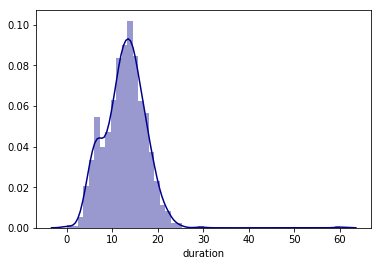

In [28]:
sns.distplot(talks_df['duration'], color='darkblue')  # In minutes

## Top 20 events by number of talks

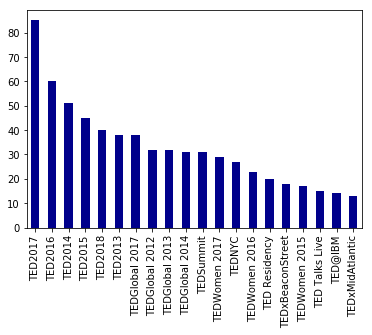

In [29]:
talks_df['event'].value_counts().head(20).plot.bar(color='darkblue')

## Number of external links

**Note**: the rightmost bar is for 10+ links.

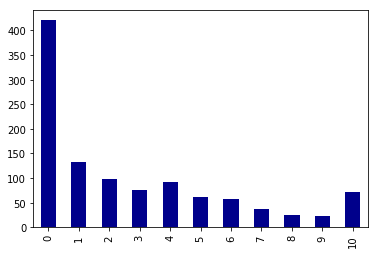

In [30]:
pd.cut(talks_df['external_links_count'],
       bins=list(range(11)) + [np.inf],
       labels=False,
       include_lowest=True).value_counts().sort_index().plot.bar(color='darkblue')

## Talks filmed by year

In [1]:
# filmed_at attribute is no more available on webpage
#talks_df.set_index('filmed_at') \
#    .resample('Y')['id'] \
#    .count() \
#    .plot.line(color='darkblue')


## Number of ratings

In [31]:
talks_df['total_ratings'].describe()

count     1092.000000
mean      1959.530220
std       3450.115796
min          3.000000
25%        628.750000
50%       1161.500000
75%       2010.750000
max      73312.000000
Name: total_ratings, dtype: float64

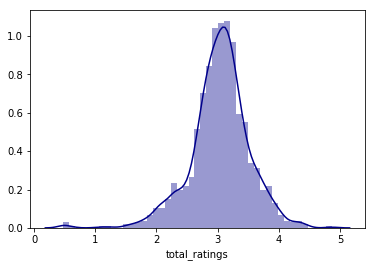

In [32]:
sns.distplot(np.log10(talks_df['total_ratings']), color='darkblue')

## Number of speakers

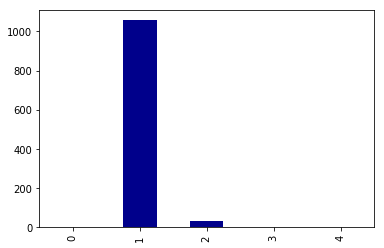

In [33]:
talks_df['speakers_count'].value_counts().sort_index().plot.bar(color='darkblue')

## Number of tags

**Note**: the rightmost bar is for 20+ tags.

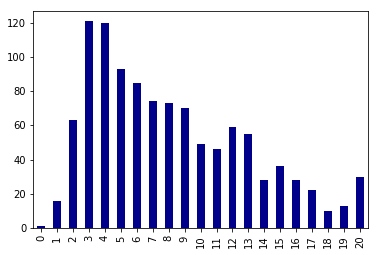

In [34]:
pd.cut(talks_df['tags_count'],
       bins=list(range(21)) + [np.inf],
       labels=False,
       include_lowest=True).value_counts().sort_index().plot.bar(color='darkblue')

## Distribution of views and views/day

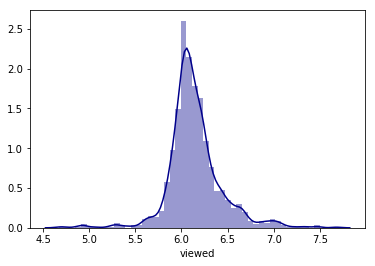

In [35]:
sns.distplot(np.log10(talks_df['viewed']), color='darkblue')

In [37]:
#sns.distplot(np.log10(talks_df['views_per_day']), color='darkblue')

## Spearman correlations with views/day

In [38]:
columns = talks_df.select_dtypes(exclude=['datetime', 'object']).columns
rating_corr = pd.DataFrame({
    'variable': columns,
    'r': [spearmanr(talks_df[x], talks_df['views_per_day']).correlation for x in columns],
}).sort_values('r')

In [39]:
rating_corr[np.abs(rating_corr['r']) > 0.1]

,r,variable
12,-0.393055,rated_longwinded
9,-0.328173,rated_ok
15,-0.297059,rated_obnoxious
10,-0.292476,rated_unconvincing
13,-0.273829,rated_confusing
23,-0.191546,tagged_global_issues
21,-0.180779,rated_jaw-dropping
32,-0.154440,tagged_entertainment
29,-0.147298,tagged_design
5,-0.142400,publishing_delay
